In [2]:
import matplotlib.pyplot as plt
import numpy as np

import error_generators as _eg
from IPython.display import display
from importlib import reload
from scipy.linalg import expm, logm
import sympy as _sp

In [3]:
from pygsti.modelpacks import smq1Q_XYZI as std
target_model = std.target_model()
meas_0 = target_model[('Mdefault')]['0'].to_dense()
meas_1 = target_model[('Mdefault')]['1'].to_dense()
rho0 = target_model['rho0']
rho0 = rho0.to_dense()
mat_Gx = target_model[('Gxpi2', 0)].to_dense()
mat_Gy = target_model[('Gypi2', 0)].to_dense()

In [4]:
meas_1

array([ 0.70710678,  0.        ,  0.        , -0.70710678])

In [5]:
rho0

array([0.70710678, 0.        , 0.        , 0.70710678])

In [6]:
mat_Gx

array([[ 1.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 0.00000000e+00,  1.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  1.57009246e-16,
        -1.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00,
         1.57009246e-16]])

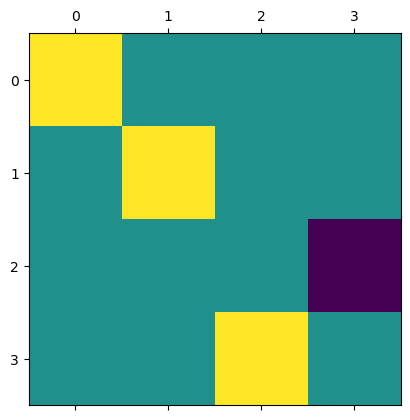

In [7]:
plt.matshow((mat_Gx))

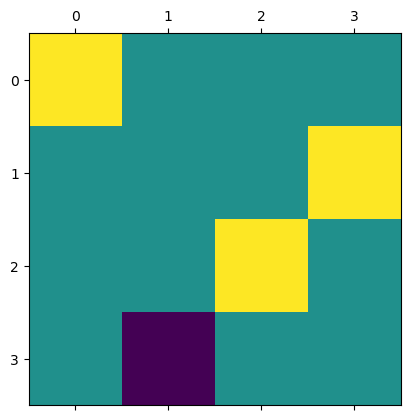

In [8]:
plt.matshow((mat_Gy))

In [9]:
# investigating the pygsti superop_for_perfeact_twirl
def _super_op_for_perfect_twirl(wrt, eps):
    """Return super operator for doing a perfect twirl with respect to wrt.
    """
    assert wrt.shape[0] == wrt.shape[1]  # only square matrices allowed
    dim = wrt.shape[0]
    SuperOp = np.zeros((dim**2, dim**2), 'complex')

    # Get spectrum and eigenvectors of wrt
    wrtEvals, wrtEvecs = np.linalg.eig(wrt)
    wrtEvecsInv = np.linalg.inv(wrtEvecs)

    # We want to project  X -> M * (Proj_i * (Minv * X * M) * Proj_i) * Minv,
    # where M = wrtEvecs. So A = B = M * Proj_i * Minv and so
    # superop = A tensor B^T == A tensor A^T
    # NOTE: this == (A^T tensor A)^T while *Maple* germ functions seem to just
    # use A^T tensor A -> ^T difference
    for i in range(dim):
        # Create projector onto i-th eigenspace (spanned by i-th eigenvector
        # and other degenerate eigenvectors)
        Proj_i = np.diag([(1 if (abs(wrtEvals[i] - wrtEvals[j]) <= eps)
                            else 0) for j in range(dim)])
        A = np.dot(wrtEvecs, np.dot(Proj_i, wrtEvecsInv))
        #if _np.linalg.norm(A.imag) > 1e-6:
        #    print("DB: imag = ",_np.linalg.norm(A.imag))
        #assert(_np.linalg.norm(A.imag) < 1e-6)
        #A = _np.real(A)
        # Need to normalize, because we are overcounting projectors onto
        # subspaces of dimension d > 1, giving us d * Proj_i tensor Proj_i^T.
        # We can fix this with a division by tr(Proj_i) = d.
        SuperOp += np.kron(A, A.T) / np.trace(Proj_i)
        # SuperOp += _np.kron(A.T,A) # Mimic Maple version (but I think this is
        # wrong... or it doesn't matter?)
    return SuperOp  # a op_dim^2 x op_dim^2 matrix

In [10]:
reload(_eg)

<module 'error_generators' from '/home/jpmarceaux/PycharmProjects/ErrorGenerators/error_generators.py'>

In [11]:
ebasis = _eg.EEBasis(1)

/home/jpmarceaux/anaconda3/envs/ErrorGenerators/lib/python3.10/site-packages/pygsti/modelmembers/operations/lindbladerrorgen.py:1691: UserWarning: Using 'CPTP' as a Lindblad type is deprecated, and you should now use 'CPTPLND'
  _warnings.warn("Using 'CPTP' as a Lindblad type is deprecated, and you should now use 'CPTPLND'")


In [12]:
my_unitary = np.round(mat_Gy@mat_Gx)

In [13]:
projector = np.round(_super_op_for_perfect_twirl(my_unitary, 1e-8), 6)

In [14]:
commuting_egen = (projector@ebasis.mat.reshape(16, 1)).reshape(4,4)

In [15]:
commuting_egen@my_unitary - my_unitary@commuting_egen

Matrix([
[0, 0, 0, 0],
[0, 0, 0, 0],
[0, 0, 0, 0],
[0, 0, 0, 0]])

In [20]:
np.linalg.eigvals(mat_Gx)

array([1.57009246e-16+1.j, 1.57009246e-16-1.j, 1.00000000e+00+0.j,
       1.00000000e+00+0.j])

In [16]:
commuting_egen

Matrix([
[                                                                              0,                                                                                                                                                          0,                                                                                                                                                          0,                                                                                                                                                          0],
[ 1.333332*{A}^{XxY}_{Gq0} + 1.333332*{A}^{XxZ}_{Gq0} - 1.333332*{A}^{YxZ}_{Gq0},                                                                                  -1.333332*{S}^{X}_{Gq0} - 1.333332*{S}^{Y}_{Gq0} - 1.333332*{S}^{Z}_{Gq0},  0.666666*{C}^{XxY}_{Gq0} - 0.666666*{C}^{XxZ}_{Gq0} - 0.666666*{C}^{YxZ}_{Gq0} + 0.666666*{H}^{X}_{Gq0} + 0.666666*{H}^{Y}_{Gq0} - 0.666666*{H}^{Z}_{Gq0}, -0.666666*{C}^{XxY}_{Gq0} + 0.666666*{C}^{XxZ}

In [17]:
ebasis.extract_rates(commuting_egen)

100%|██████████| 12/12 [00:00<00:00, 160.74it/s]


{('H', ('X',), (0,)): 0.333333*{H}^{X}_{Gq0} + 0.333333*{H}^{Y}_{Gq0} - 0.333333*{H}^{Z}_{Gq0},
 ('H', ('Y',), (0,)): 0.333333*{H}^{X}_{Gq0} + 0.333333*{H}^{Y}_{Gq0} - 0.333333*{H}^{Z}_{Gq0},
 ('H', ('Z',), (0,)): -0.333333*{H}^{X}_{Gq0} - 0.333333*{H}^{Y}_{Gq0} + 0.333333*{H}^{Z}_{Gq0},
 ('S', ('X',), (0,)): 0.333333*{S}^{X}_{Gq0} + 0.333333*{S}^{Y}_{Gq0} + 0.333333*{S}^{Z}_{Gq0},
 ('C', ('X', 'Y'), (0,)): 0.333333*{C}^{XxY}_{Gq0} - 0.333333*{C}^{XxZ}_{Gq0} - 0.333333*{C}^{YxZ}_{Gq0},
 ('A', ('X', 'Y'), (0,)): 0.333333*{A}^{XxY}_{Gq0} + 0.333333*{A}^{XxZ}_{Gq0} - 0.333333*{A}^{YxZ}_{Gq0},
 ('C', ('X', 'Z'), (0,)): -0.333333*{C}^{XxY}_{Gq0} + 0.333333*{C}^{XxZ}_{Gq0} + 0.333333*{C}^{YxZ}_{Gq0},
 ('A', ('X', 'Z'), (0,)): 0.333333*{A}^{XxY}_{Gq0} + 0.333333*{A}^{XxZ}_{Gq0} - 0.333333*{A}^{YxZ}_{Gq0},
 ('S', ('Y',), (0,)): 0.333333*{S}^{X}_{Gq0} + 0.333333*{S}^{Y}_{Gq0} + 0.333333*{S}^{Z}_{Gq0},
 ('C', ('Y', 'Z'), (0,)): -0.333333*{C}^{XxY}_{Gq0} + 0.333333*{C}^{XxZ}_{Gq0} + 0.333333*{C}^

In [18]:
ebasis.vec

[{H}^{X}_{Gq0},
 {H}^{Y}_{Gq0},
 {H}^{Z}_{Gq0},
 {S}^{X}_{Gq0},
 {C}^{XxY}_{Gq0},
 {A}^{XxY}_{Gq0},
 {C}^{XxZ}_{Gq0},
 {A}^{XxZ}_{Gq0},
 {S}^{Y}_{Gq0},
 {C}^{YxZ}_{Gq0},
 {A}^{YxZ}_{Gq0},
 {S}^{Z}_{Gq0}]

In [19]:
ebasis.bmat(ebasis.vec[0])

array([[ 0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.],
       [ 0.,  0.,  0., -2.],
       [ 0.,  0.,  2.,  0.]])